In [85]:
# Visualize numerical columns
# scatter_matrix(df[numerical_columns], figsize=(15, 15), diagonal='kde', alpha=0.2)

In [24]:
from datetime import datetime

import pandas as pd

import xgboost as xgb
import lightgbm as lgb
# import catboost as cb

import numpy as np

import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

In [25]:
# Read CSV
df = pd.read_csv('../data/DontGetKicked/training.csv')

# Show df info
df.info()

# Show feature statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,72983.000000,72983.000000,72983.000000,72983.000000,69814.000000,72983.000000,72965.000000,72965.000000,72965.000000,72965.000000,72668.000000,72668.000000,72668.000000,72668.000000,72983.000000,72983.000000,72983.000000,72983.000000,72983.000000
mean,36511.428497,0.122988,2005.343052,4.176644,1.494299,71499.995917,6128.909217,7373.636031,8497.034332,9850.928240,6132.081287,7390.681827,8775.723331,10145.385314,26345.842155,58043.059945,6730.934326,0.025280,1276.580985
std,21077.241302,0.328425,1.731252,1.712210,0.521290,14578.913128,2461.992768,2722.491986,3156.285284,3385.789541,2434.567723,2686.248852,3090.702941,3310.254351,25717.351219,26151.640415,1767.846435,0.156975,598.846788
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18257.500000,0.000000,2004.000000,3.000000,1.000000,61837.000000,4273.000000,5406.000000,6280.000000,7493.000000,4275.000000,5414.000000,6536.000000,7784.000000,17212.000000,32124.000000,5435.000000,0.000000,837.000000
50%,36514.000000,0.000000,2005.000000,4.000000,1.000000,73361.000000,6097.000000,7303.000000,8444.000000,9789.000000,6062.000000,7313.000000,8729.000000,10103.000000,19662.000000,73108.000000,6700.000000,0.000000,1155.000000
75%,54764.500000,0.000000,2007.000000,5.000000,2.000000,82436.000000,7765.000000,9021.000000,10651.000000,12088.000000,7736.000000,9013.000000,10911.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,45469.000000,1.000000,7498.000000


In [ ]:
f_month = lambda date_string: datetime.strptime(date_string, "%m/%d/%Y").strftime("%B")
f_weekday = lambda date_string: datetime.strptime(date_string, "%m/%d/%Y").strftime("%A")

df['PurchMoth'] = df['PurchDate'].apply(f_month)
df['PurchWeekday'] = df['PurchDate'].apply(f_weekday)

0           Monday
1           Monday
2           Monday
3           Monday
4           Monday
           ...    
72978    Wednesday
72979    Wednesday
72980    Wednesday
72981    Wednesday
72982    Wednesday
Name: PurchDate, Length: 72983, dtype: object

In [19]:
df['Trim'].value_counts()

Trim
Bas    13950
LS     10174
SE      9348
SXT     3825
LT      3540
       ...  
Har        1
LL         1
JLX        1
JLS        1
L 3        1
Name: count, Length: 134, dtype: int64

In [26]:
categorical_columns = [
    'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
    'VehYear', 'Transmission', 'WheelType', 'Nationality', 'Size', 
    'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST',
    'WheelTypeID', 'VNZIP1', 'IsOnlineSale'
]

df[categorical_columns] = df[categorical_columns].astype('category')

mutual_info_classif(df[categorical_columns], df['IsBadBuy'])

ValueError: Input contains NaN

In [28]:
df[categorical_columns].isna().sum()

Auction                     0
Make                        0
Model                       0
Trim                     2360
SubModel                    8
Color                       8
VehYear                     0
Transmission                9
WheelType                3174
Nationality                 5
Size                        5
TopThreeAmericanName        5
PRIMEUNIT               69564
AUCGUART                69564
VNST                        0
WheelTypeID              3169
VNZIP1                      0
IsOnlineSale                0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

<Axes: >

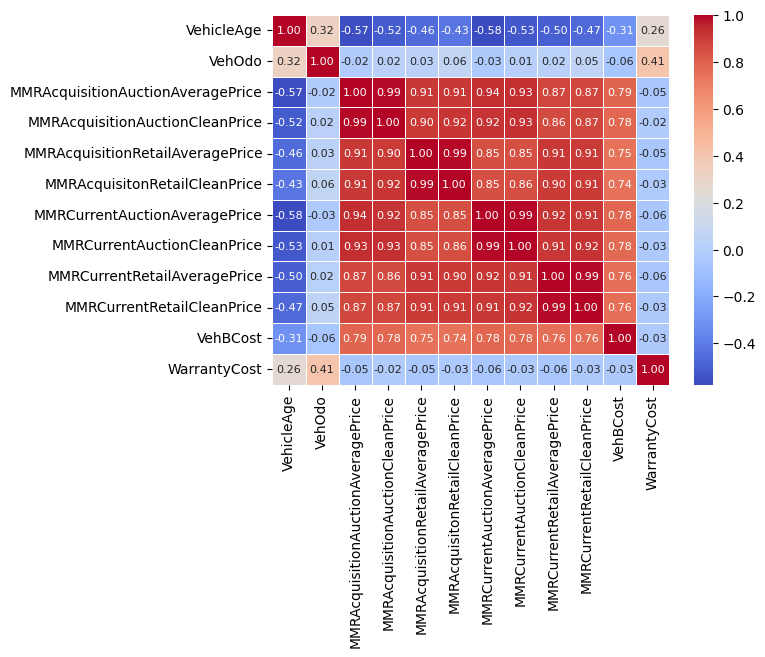

In [3]:
numerical_columns = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'
]

corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", annot_kws={"size": 8})  # Smaller annotation size

In [88]:
# Dropping unnecessary columns
df = df.drop(columns=['PurchDate', 'RefId', 'BYRNO'])

# Categorical columns
categorical_columns = [
    'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
    'VehYear', 'Transmission', 'WheelType', 'Nationality', 'Size', 
    'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST',
    'WheelTypeID', 'VNZIP1', 'IsOnlineSale'
]

# Numerical columns
numerical_columns = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'
]

# # Replace zeros in numerical columns with nan to impute them later
df[numerical_columns] = df[numerical_columns].replace(0, np.nan)

# Check percentage of rows with nan values
df[numerical_columns].isna().sum() / df.shape[0]

VehicleAge                           0.000027
VehOdo                               0.000000
MMRAcquisitionAuctionAveragePrice    0.011592
MMRAcquisitionAuctionCleanPrice      0.009797
MMRAcquisitionRetailAveragePrice     0.011592
MMRAcquisitonRetailCleanPrice        0.011592
MMRCurrentAuctionAveragePrice        0.011222
MMRCurrentAuctionCleanPrice          0.009495
MMRCurrentRetailAveragePrice         0.011222
MMRCurrentRetailCleanPrice           0.011222
VehBCost                             0.000000
WarrantyCost                         0.000000
dtype: float64

In [89]:
# Define imputers for numerical and categorical data
num_imputer = SimpleImputer(strategy='median')  # Median for numerical data
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode for categorical data

# Impute numerical columns
df[numerical_columns] = num_imputer.fit_transform(df[numerical_columns])

# Impute categorical columns
df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

# Convert WheelTypeId to int
df['WheelTypeID'] = df['WheelTypeID'].astype(int)

# Convert appropriate columns to 'category' dtype
df[categorical_columns] = df[categorical_columns].astype('category')

# Define scaler for numerical data
standard_scaler = StandardScaler()

# Scale numerical features
df[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])

In [90]:
# Get features and target
X = df.drop(columns=['IsBadBuy'])
y = df['IsBadBuy']

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3 
)

In [91]:
# clf = xgb.XGBClassifier(enable_categorical=True)
# clf.fit(X_train, y_train)

# clf = cb.CatBoostClassifier(cat_features=categorical_columns)
# clf.fit(X_train, y_train)

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(
    X_train,
    y_train,
    categorical_feature=[X.columns.get_loc(col) for col in categorical_columns],
    eval_set=[(X_test, y_test)],
    eval_metric='logloss',
)

y_pred = clf.predict(X_test)

print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

print(f"Precision: {precision_score(y_test, y_pred)}")

print(f"Recall: {recall_score(y_test, y_pred)}")

print(f"F1: {f1_score(y_test, y_pred)}")

print("Confusion matrix")
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 6282, number of negative: 44806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4340
[LightGBM] [Info] Number of data points in the train set: 51088, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122964 -> initscore=-1.964654
[LightGBM] [Info] Start training from score -1.964654
ROC AUC: 0.5255878817558802
Accuracy: 0.8765014843571591
Precision: 0.48502994011976047
Recall: 0.060133630289532294
F1: 0.10700132100396301
Confusion matrix
[[19029   172]
 [ 2532   162]]


In [92]:
test_df = pd.read_csv('../data/DontGetKicked/test.csv')

In [93]:
test_df = test_df.drop(columns=['PurchDate', 'BYRNO'])

# Categorical columns
categorical_columns = [
    'Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 
    'VehYear', 'Transmission', 'WheelType', 'Nationality', 'Size', 
    'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST',
    'WheelTypeID', 'VNZIP1', 'IsOnlineSale'
]

# Numerical columns
numerical_columns = [
    'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 
    'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 
    'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 
    'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 
    'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'
]

# # Replace zeros in numerical columns with nan to impute them later
test_df[numerical_columns] = test_df[numerical_columns].replace(0, np.nan)

# Define imputers for numerical and categorical data
num_imputer = SimpleImputer(strategy='median')  # Median for numerical data
cat_imputer = SimpleImputer(strategy='most_frequent')  # Mode for categorical data

# Impute numerical columns
test_df[numerical_columns] = num_imputer.fit_transform(test_df[numerical_columns])

# Impute categorical columns
test_df[categorical_columns] = cat_imputer.fit_transform(test_df[categorical_columns])

# Convert WheelTypeId to int
test_df['WheelTypeID'] = test_df['WheelTypeID'].astype(int)

# Convert appropriate columns to 'category' dtype
test_df[categorical_columns] = test_df[categorical_columns].astype('category')

# Define scaler for numerical data
standard_scaler = StandardScaler()

# Scale numerical features
test_df[numerical_columns] = standard_scaler.fit_transform(test_df[numerical_columns])

In [94]:
y_pred = clf.predict(test_df.drop(columns=['RefId']))
submission_df = pd.DataFrame(data=np.stack([test_df['RefId'].values, y_pred], axis=1), columns=['RefId', 'IsBadBuy'])

In [95]:
submission_df

,RefId,IsBadBuy
0,73015,0
1,73016,0
2,73017,0
3,73018,0
4,73019,0
...,...,...
48702,121742,0
48703,121743,0
48704,121744,0
48705,121745,0


In [96]:
submission_df.to_csv('../results/DontGetKicked/submission.csv', index=False)